<a href="https://colab.research.google.com/github/santinon/ML-DL_perso_learn_projects/blob/main/2_CNN_Projects_Smile_detection_%26_hand_signs_recognition_with_tensorflow_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Applications with Keras/TF

# 2 Classification Projects: 
- **Smile recognition**= Binary classification
- **Numbers shown by hand recognition (from 0 to 5)** = Multi-class classification


A note about Tensorflow : TF a is programming framework from Google. 

I used this ressource for this work : A tutorial from Coursera, DeepLearning Specialization (Andrew NG), Deeplearningai

#### Packages/Libraries

(useful for all the projects)

In [24]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import tensorflow as tf
from tensorflow.python.framework import ops
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl

# allow to have access to the data stored already on drive of google
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Some functions useful for later 

(skip this part)

In [25]:
# this is my private path on google collab, use you own if you implement this
# download just the 4 files from my Github before. 
path = "/content/gdrive/MyDrive/Canada MILA/FAC/COURS UDEM MILA/Collab things/UDEM/coursera/Smile recognition   Hand numbers recognition with TF"

def load_happy_dataset():
    train_dataset = h5py.File(path+'/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


# this is my private path on google collab, use you own if you implement this
# download just the 4 files from my Github before. 
def load_signs_dataset():
    train_dataset = h5py.File(path+'/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches *
                                  mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches *
                                  mini_batch_size: m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # Numpy Equivalents:
    # Z1 = np.dot(W1, X) + b1
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    # Z2 = np.dot(W2, a1) + b2
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    # Z3 = np.dot(W3,Z2) + b3
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3


def predict(X, parameters):

    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.placeholder("float", [12288, 1])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction

# o - o - o - o - o - o - o - o - o - o - o - o - o

## Note : Sequential model & Functional API

Sequential model : 

- A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Sequential API requires the model to move in a linear fashion through its layers.

- **Model layer-by-layer. It is very simple and easy to use. But sharing of layers or branching of layers is not allowed. Also, you can NOT have multiple inputs or outputs.**

Functional API : 

- The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs => allows much more flexibility

- The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API.

- The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

- The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

- **Branching or sharing of layers is allowed. Can have multiple inputs and outputs**.


# Project 1 : Recognizing smilling people images


following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`.

###Load the Data and Split the Data into Train/Test Sets

Happy House dataset for this part of the assignment, which contains images of peoples' faces. Your task will be to build a ConvNet that determines whether the people in the images are smiling or not

In [26]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print("Y_train_orig shape before reshaping : ", Y_train_orig.shape)
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train_orig shape before reshaping :  (1, 600)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


In [27]:
Y_train[0:5]

array([[0],
       [1],
       [1],
       [1],
       [1]])

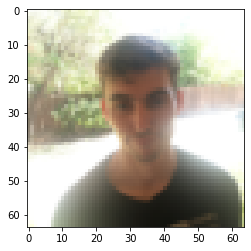

In [28]:
index = 127
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

### Tensorflow / Keras Information: 

- create a model using TF Keras' Sequential API, which allows you to build layer by layer, and is ideal for building models where each layer has **exactly one** input tensor and **one** output tensor (is only appropriate for simpler, more straightforward tasks). 

-  think of a Sequential model as behaving like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters.  

- If your model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice!

- For any layer construction in Keras, you'll need to specify the input shape in advance (shape of the weights is based on the shape of the inputs).

### Create the Sequential Model

following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`

- [ZeroPadding2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D): padding 3, input shape 64 x 64 x 3
- [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 32 7x7 filters, stride 1 (e.g. spatial convolution over images)
- [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): for axis 3
- [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
- [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Using default parameters
- [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
- Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 1 neuron and a sigmoid activation. 


In [29]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    
    model = tf.keras.Sequential([
                                 
            # input shape of 64 x 64 x 3                     
            tf.keras.Input(shape=(64 , 64 ,3)),

            # ZeroPadding2D with padding 3
            tfl.ZeroPadding2D(padding=3),#tensorflow.keras.layers shorthand = tfl

            # Conv2D with 32 7x7 filters and stride of 1
            # (spatial convolution over images)
            tfl.Conv2D(filters=32,kernel_size=7,strides=1),

            # BatchNormalization for axis 3
            tfl.BatchNormalization(axis=3, momentum=0.99, epsilon=0.001),

            # ReLU
            tfl.ReLU(),

            # Max Pooling 2D with default parameters
            tfl.MaxPool2D(),

            # Flatten layer
            tfl.Flatten(),

            # Dense layer with 1 unit for output & 'sigmoid' activation
            tfl.Dense(1,activation='sigmoid')
        ])
    
    return model

#### Compilation 

model is created, now you can compile it for training with an optimizer, loss and metrics of your choice. 

In [30]:
happy_model = happyModel()
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

#### check the layers

In [31]:
# Print a summary for each layer
happy_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 70, 70, 3)        0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                      

### Train and Evaluate the Model

In [32]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 9s 170ms/step - loss: 1.1977 - accuracy: 0.7167
Epoch 2/10
38/38 [==============================] - 7s 182ms/step - loss: 0.1853 - accuracy: 0.9383
Epoch 3/10
38/38 [==============================] - 6s 169ms/step - loss: 0.1564 - accuracy: 0.9400
Epoch 4/10
38/38 [==============================] - 6s 164ms/step - loss: 0.1155 - accuracy: 0.9533
Epoch 5/10
38/38 [==============================] - 6s 164ms/step - loss: 0.0999 - accuracy: 0.9667
Epoch 6/10
38/38 [==============================] - 6s 157ms/step - loss: 0.1010 - accuracy: 0.9600
Epoch 7/10
38/38 [==============================] - 6s 158ms/step - loss: 0.1060 - accuracy: 0.9683
Epoch 8/10
38/38 [==============================] - 6s 157ms/step - loss: 0.2909 - accuracy: 0.9067
Epoch 9/10
38/38 [==============================] - 6s 148ms/step - loss: 0.1104 - accuracy: 0.9567
Epoch 10/10
38/38 [==============================] - 6s 169ms/step - loss: 0.1100 - accuracy: 0.9500

In [33]:
# binary_crossentropy and the accuracy respectively
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 1s 74ms/step - loss: 0.1218 - accuracy: 0.9467


[0.12177974730730057, 0.9466666579246521]

# Project 2:  Hand signs indicating numbers from 0 to 5 (6 classes classification) with Tensorflow

**Sequential model**
- A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Sequential API requires the model to move in a linear fashion through its layers.


**Functional API**
- The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs => allows much more flexibility 

- The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. 

- The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

- The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.


## Load the SIGNS Dataset



In [34]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 5


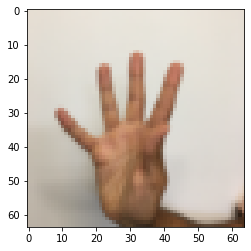

In [35]:
# Example of an image from the dataset
index = 12
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

## Split the Data into Train/Test Sets

In [36]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print("\nY_train_orig looks like :", Y_train_orig)
print ("Y_train_orig shape: " + str(Y_train_orig.shape))
print ("Y_train shape: " + str(Y_train.shape))
print("Y_train", Y_train)
print ("\nX_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)

Y_train_orig looks like : [[5 0 2 ... 2 4 5]]
Y_train_orig shape: (1, 1080)
Y_train shape: (1080, 6)
Y_train [[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## Forward Propagation (Convolutional Model)

Begin building your graph of layers by creating an input node that functions as a callable object:

- **input_img = tf.keras.Input(shape=input_shape):** 

Then, create a new node in the graph of layers by calling a layer on the `input_img` object: 

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):** Read the full documentation on [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` downsamples your input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, you usually operate on a single example at a time and a single channel at a time. Read the full documentation on [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** computes the elementwise ReLU of Z (which can be any shape). You can read the full documentation on [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  

    * If a tensor P has the shape (batch_size,h,w,c), it returns a flattened tensor with shape (batch_size, k), where k=h * w *  c.  "k" equals the product of all the dimension sizes other than the first dimension.
    
    * For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** given the flattened input F, it returns the **output** computed using a fully connected layer. You can read the full documentation on [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).


#### **Window, kernel, filter, pool**

The words "kernel" and "filter" are used to refer to the same thing. The word "filter" accounts for the amount of "kernels" that will be used in a single convolution layer. "Pool" is the name of the operation that takes the max or average value of the kernels. 

This is why the parameter `pool_size` refers to `kernel_size`, and you use `(f,f)` to refer to the filter size. 

Pool size and kernel size refer to the same thing in different objects - They refer to the shape of the window where the operation takes place. 

the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`

 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 4 by 4 filters, stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 2 by 2 filters, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 6 neurons and a softmax activation. 

In [37]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """


    input_img = tf.keras.Input(shape=input_shape)
    
    # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    # note : the size of the output image is equal to the input image = "SAME"
    Z1 = tfl.Conv2D(filters= 8. , kernel_size=4 , padding='same',strides=1)(input_img)

    # RELU
    A1 = tfl.ReLU()(Z1)

    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='SAME')(A1)

    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters= 16. , kernel_size=2 , padding='same',strides=1)(P1)

    # RELU
    A2 =  tfl.ReLU()(Z2)

    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='SAME')(A2)

    # FLATTEN
    F = tfl.Flatten()(P2)

    # Dense layer with 6 neurons in output layer
    outputs = tfl.Dense(units= 6 , activation='softmax')(F)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)    
    
    return model

In [38]:
conv_model = convolutional_model((64, 64, 3))

conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 8)         392       
                                                                 
 re_lu_4 (ReLU)              (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_5 (ReLU)              (None, 8, 8, 16)          0         
                                                           

## Train the Model

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 5s 262ms/step - loss: 1.8060 - accuracy: 0.1667 - val_loss: 1.7893 - val_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 3s 206ms/step - loss: 1.7865 - accuracy: 0.2546 - val_loss: 1.7809 - val_accuracy: 0.3250
Epoch 3/100
17/17 [==============================] - 4s 216ms/step - loss: 1.7786 - accuracy: 0.3102 - val_loss: 1.7740 - val_accuracy: 0.3417
Epoch 4/100
17/17 [==============================] - 3s 203ms/step - loss: 1.7712 - accuracy: 0.3213 - val_loss: 1.7670 - val_accuracy: 0.3833
Epoch 5/100
17/17 [==============================] - 2s 148ms/step - loss: 1.7639 - accuracy: 0.3731 - val_loss: 1.7590 - val_accuracy: 0.4000
Epoch 6/100
17/17 [==============================] - 3s 172ms/step - loss: 1.7555 - accuracy: 0.4222 - val_loss: 1.7493 - val_accuracy: 0.4083
Epoch 7/100
17/17 [==============================] - 3s 166ms/step - loss: 1.7455 - accuracy: 0.4389 - val_loss: 1.7378 - val_accuracy: 0.4583

## History Object

The history object is an output of the .fit() operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve

In [40]:
history.history
# here, we have : accuracy, loss, val_accuracy, val_loss

{'accuracy': [0.1666666716337204,
  0.25462964177131653,
  0.31018519401550293,
  0.3212963044643402,
  0.3731481432914734,
  0.42222222685813904,
  0.43888887763023376,
  0.4472222328186035,
  0.4731481373310089,
  0.49537035822868347,
  0.5138888955116272,
  0.5277777910232544,
  0.5416666865348816,
  0.5546296238899231,
  0.5620370507240295,
  0.5592592358589172,
  0.5796296000480652,
  0.5759259462356567,
  0.5944444537162781,
  0.604629635810852,
  0.6166666746139526,
  0.6268518567085266,
  0.6435185074806213,
  0.6564815044403076,
  0.6675925850868225,
  0.6722221970558167,
  0.6842592358589172,
  0.6907407641410828,
  0.6962962746620178,
  0.7037037014961243,
  0.7074074149131775,
  0.7194444537162781,
  0.7222222089767456,
  0.7259259223937988,
  0.7314814925193787,
  0.7388888597488403,
  0.7453703880310059,
  0.7490741014480591,
  0.7527777552604675,
  0.7583333253860474,
  0.760185182094574,
  0.7638888955116272,
  0.7657407522201538,
  0.7712963223457336,
  0.7787036895751

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

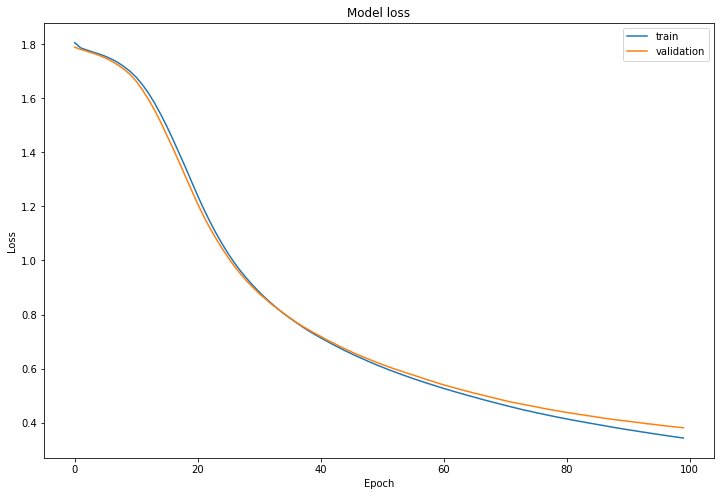

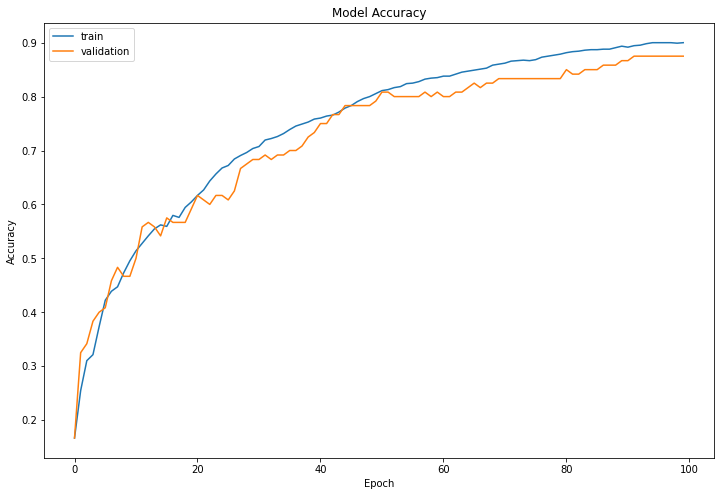

In [41]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on.

df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]

df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]

df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')